In [2]:
#necesary imports

import matplotlib.font_manager as fm
import logging
import pickle
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
import joblib
fm._log.setLevel(logging.WARNING)
from src import data_loading
from src import preprocessing
from src import visualize_data
from src import feature_engenieering
from src import modeling
from src import evaluation
from src import model_compare
from src import inference
from src.inference_jupyter_form import create_input_form

2025-01-16 18:32:01.532801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Salary Predictive model.

# Table of Contents

## [1. Data Loading and Preprocessing](#1-data-loading-and-preprocessing)
### [1.1. Loading Data](#11-loading-data)
### [1.2. Data Cleansing and Imputation](#12-data-cleansing-and-imputation)
### [1.3. Data Visualization](#13-data-visualization)

## [2. Feature Engineering and Data Splitting](#2-feature-engineering-and-data-splitting)
### [2.1. Splitting Data](#21-splitting-data)
### [2.2. Data Normalization and Scaling](#22-data-normalization-and-scaling)

## [3. Model Training and Evaluation](#3-model-training-and-evaluation)
### [3.1. Baseline Model: Dummy Regressor](#31-baseline-model-dummy-regressor)
### [3.2. Random Forest Regressor](#32-random-forest-regressor)
### [3.3. RFR initial testing](#33-rfr-initial-testing)
### [3.4. Feature Selection Process](#34-feature-selection-process)
### [3.5. Neural Network Model](#35-neural-network-model)
### [3.5. Neural Network Model initial testing](#35-neural-network-model-initial-testing)

## [4. Model Comparison](#4-model-comparison)
### [4.1. Final Model Selection](#41-final-model-selection)

## [5. Inference](#5-inference)

# 1 Data Loading and preprocessing

The data preprocessing pipeline consists of several key stages to prepare the dataset for modeling:

## 1.1 Loading Data



 The `load_data` function in `data_loading.py` loads multiple CSV files and merges them into a single DataFrame using the 'id' column as the merging key.



In [2]:

#files path for the raw dataset:

data_files = ['./data/people.csv','./data/descriptions.csv','./data/salary.csv',]


#merge datasets in a cohesive Dataframe

full_dataset = data_loading.load_data(data_files)


## 1.2 Data cleansing and imputation

The `infer_missing_values_in_dataframe` function in `llm_dataset_filler.py` uses a local LLM to infer missing values for specific fields (e.g., Age, Gender, Education Level) based on the provided descriptions. It utilizes asynchronous calls to the LLM API and updates the DataFrame with inferred values.

In [3]:


#preprocessing of the dataframe adds missing values with LLM inference over descriptions of each row, drops the incomplete rows and cleans up the data.

cleansed_dataset = await preprocessing.preprocess(full_dataset)


DEBUG:src.llm_dataset_filler:Total rows with missing values: 14



Full Merged Dataset:
   id   Age  Gender Education Level          Job Title  Years of Experience  \
0   0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1   1  28.0  Female        Master's       Data Analyst                  3.0   
2   2  45.0    Male             PhD     Senior Manager                 15.0   
3   3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4   4  52.0    Male        Master's           Director                 20.0   

                                         Description    Salary  
0  I am a 32-year-old male working as a Software ...   90000.0  
1  I am a 28-year-old data analyst with a Master'...   65000.0  
2  I am a 45-year-old Senior Manager with a PhD a...  150000.0  
3  I am a 36-year-old female Sales Associate with...   60000.0  
4  I am a 52-year-old male with over two decades ...  200000.0  
      id   Age  Gender Education Level                      Job Title  \
370  370  35.0  Female      Bachelor's  

DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 287: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Salary.
DEBUG:src.llm_dataset_filler:Index 172: Inferred Job Title: Not found
DEBUG:src.llm_dataset_filler:Index 260: Inferred Age: Not found
DEBUG:src.llm_dataset_filler:Index 287: Inferred Age: 35
DEBUG:src.llm_dataset_filler:Index 260: Inferred Salary: Not found
DEBUG:src.llm_dataset_filler:Index 261: Received NDJSON response for Education Level.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Salary.
DEBUG:src.llm_dataset_filler:Index 60: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 221: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 261: Inferred Education Level: Bachelor's
DEBUG:src.llm_dataset_filler:Index 221: Infe


Missing Values after LLM inference:
id                     0
Age                    3
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Description            3
Salary                 2
dtype: int64

Rows with Missing Values after LLM inference:
      id   Age Gender Education Level                 Job Title  \
111  111  37.0   Male      Bachelor's  Software Project Manager   
125  125  26.0   Male      Bachelor's         Junior Accountant   
172  172   NaN    NaN             NaN                       NaN   
177  177  31.0   Male      Bachelor's         Junior Accountant   
260  260   NaN    NaN             NaN                       NaN   
315  315   NaN   Male      Bachelor's  Senior Software Engineer   

     Years of Experience                                        Description  \
111                  9.0                                                NaN   
125                  2.0                                                NaN

## 1.3 Data Visualization

Im using simple visualizations for the dataset in order to see if how the datset is distributed.

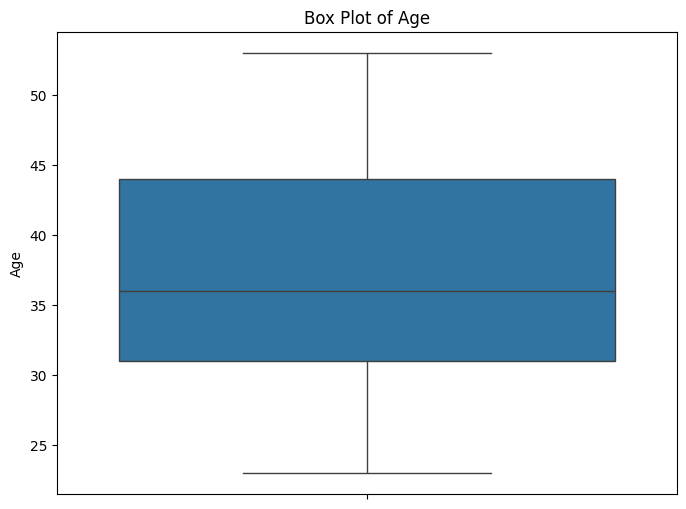

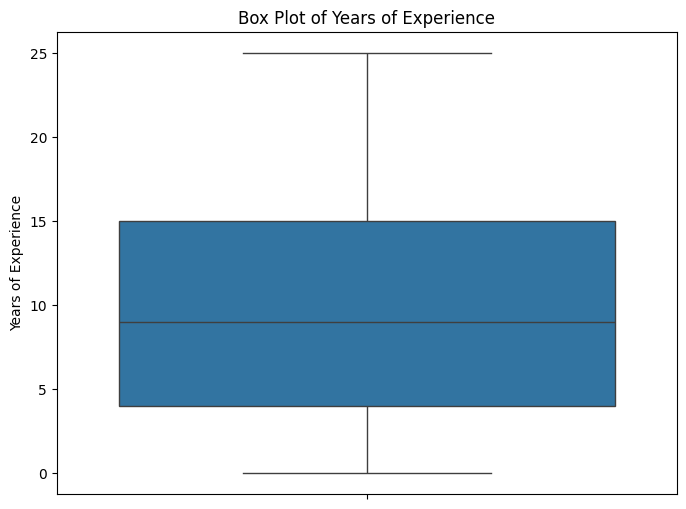

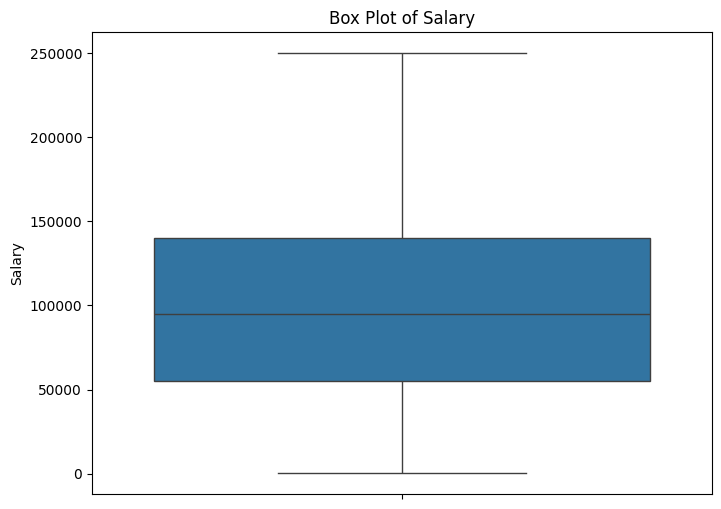

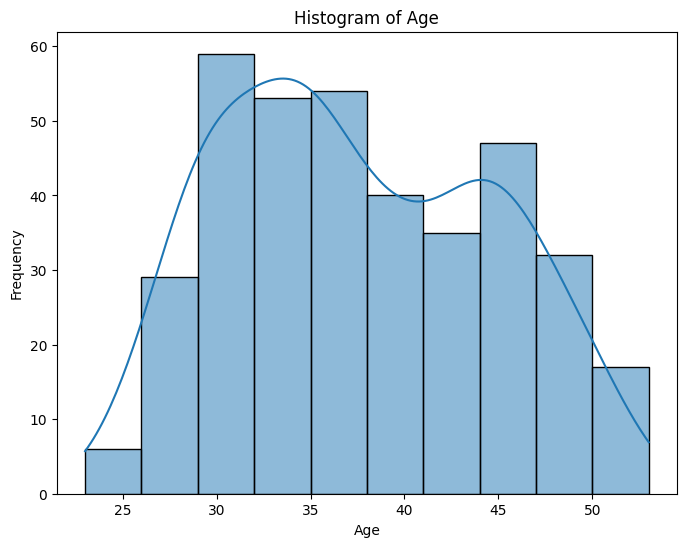

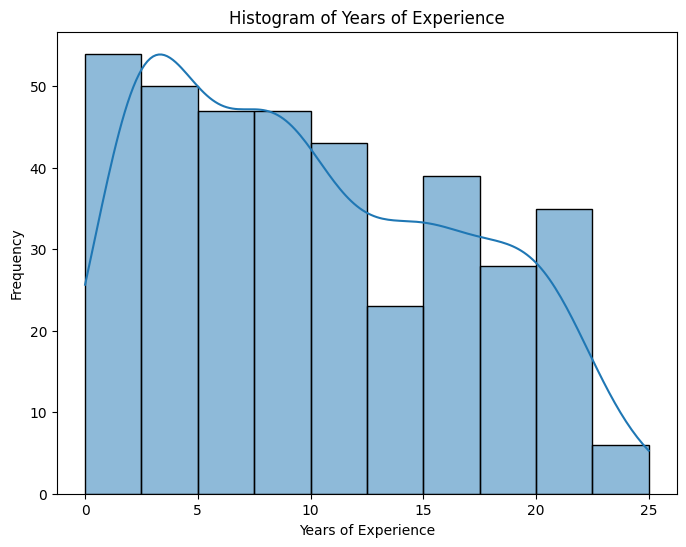

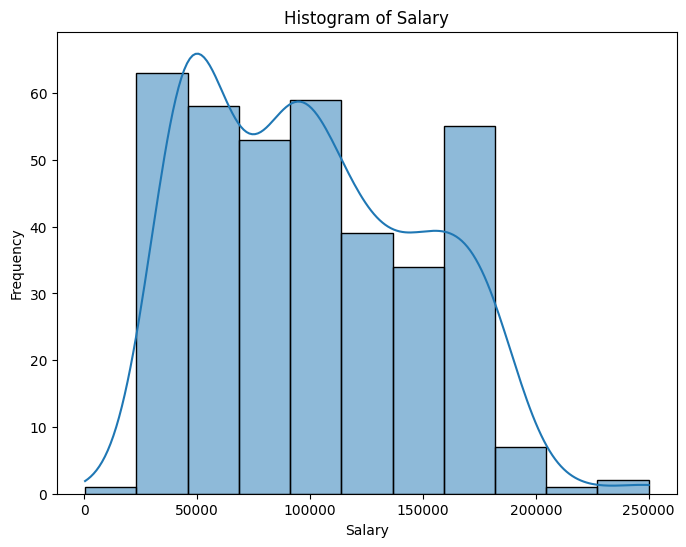

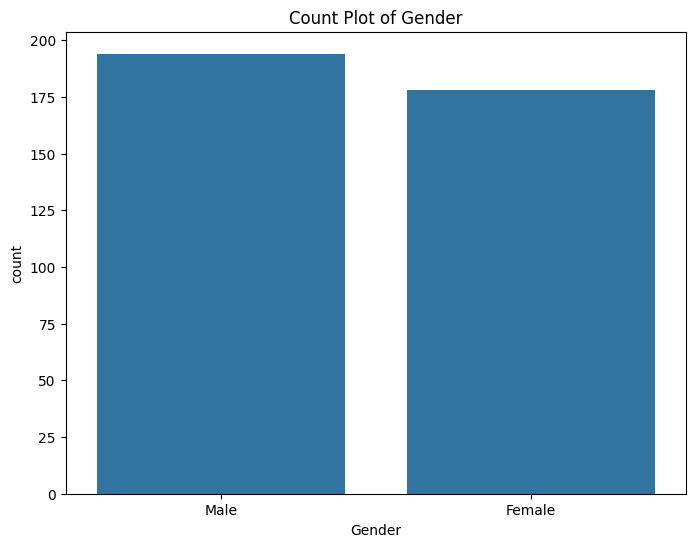

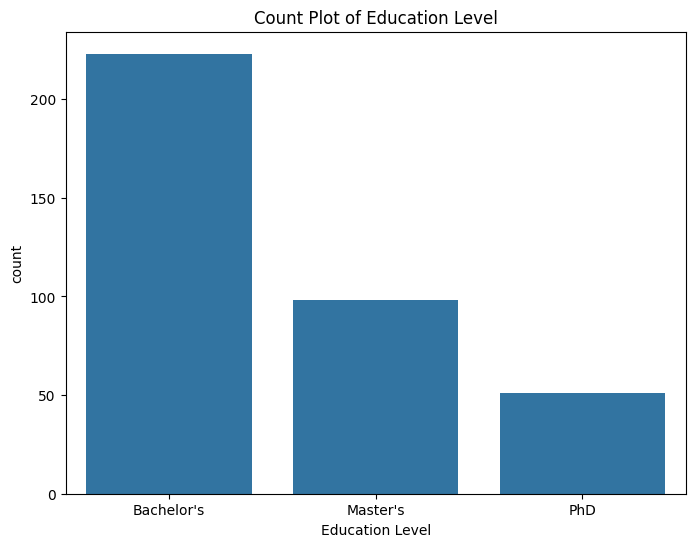

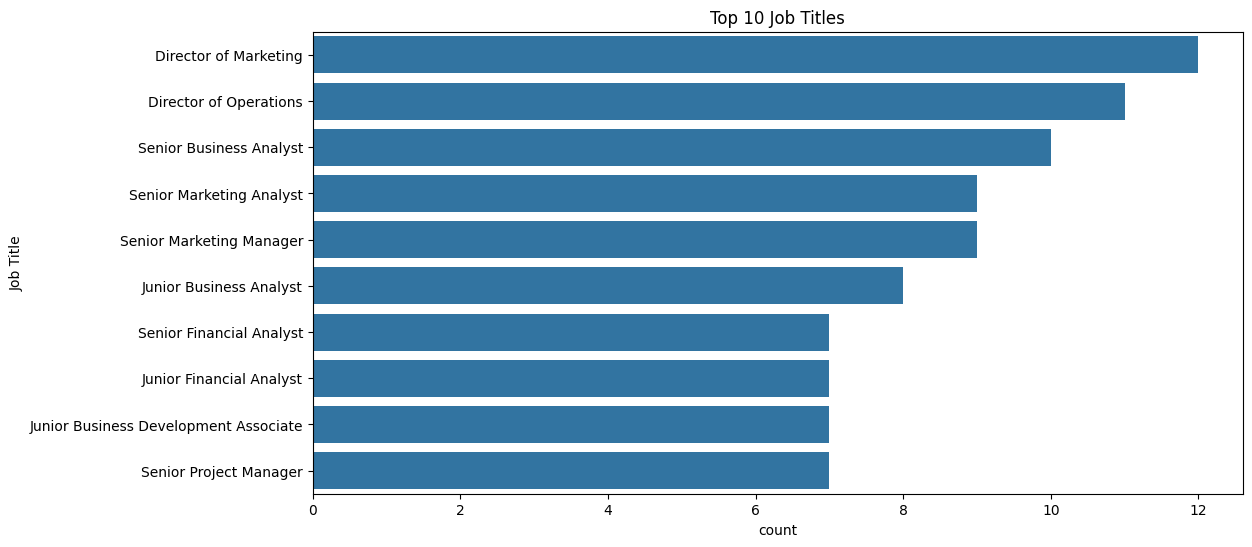

In [4]:

visualize_data.visualize_dataset(cleansed_dataset)

# 2 Feature engineering and data splitting

## 2.1 Splitting data

Dividing the dataset into training and testing subsets to evaluate model performance. This step ensures an unbiased assessment of the model's capabilities.

In [5]:

#split the dataset into an 80 / 20 ratio for training and testing.

X_train, X_test, y_train, y_test = feature_engenieering.split_data(cleansed_dataset)



## 2.2 Data Normalization and Scaling

 Normalizing and scaling data to standardize features, which helps improve model convergence and performance. unsing  Min-Max Scaling for the RNR model and Standardization for the NN model, the values for categorical features are treated case by case,for education its modeled as a linear relationship meaning 0 for bachellors m 1 for Masters and 2 for PHD, the Job title values since they have a strong correlation with salary but lack cardinality, the target encoder method seems to be the optimal. once the datasets are created are saved along with scalers and the job title target encoded table and their values in pkl format to be used later for training and inference respectibly.

In [6]:

#normalize and scale the datasets using MinMaxScaler and target encoder for random forest

normalized_X_train, te, scaler = feature_engenieering.normalize_train_data(X_train, y_train,MinMaxScaler())

normalized_X_test = feature_engenieering.normalize_test_data(X_test, te, scaler)


#normalize and scale the datasets using MinMaxScaler and target encoder for Neural Networks

normalized_X_train_nn, te_nn, scaler_nn = feature_engenieering.normalize_train_data(X_train, y_train,StandardScaler(),"nn_")

normalized_X_test_nn = feature_engenieering.normalize_test_data(X_test, te_nn, scaler_nn)

X_train.to_pickle("./data/X_train.pkl")
y_train.to_pickle("./data/y_train.pkl")
X_test.to_pickle("./data/X_test.pkl")
y_test.to_pickle("./data/y_test.pkl")
normalized_X_train.to_pickle("./data/normalized_X_train.pkl")
normalized_X_train_nn.to_pickle("./data/normalized_X_train_nn.pkl")
normalized_X_test.to_pickle("./data/normalized_X_test.pkl")
normalized_X_test_nn.to_pickle("./data/normalized_X_test_nn.pkl")


Scaler saved to ./models/scaler.pkl
Target encoder saved to ./models/target_encoder.pkl
Job title mapping saved to ./models/job_title_mapping.pkl
Inverted job title mapping saved to ./models/inverted_job_title_mapping.pkl
Scaler saved to ./models/nn_scaler.pkl
Target encoder saved to ./models/nn_target_encoder.pkl
Job title mapping saved to ./models/nn_job_title_mapping.pkl
Inverted job title mapping saved to ./models/nn_inverted_job_title_mapping.pkl


# 3 Model Training and Evaluation

The first step is to load all the relevant files in memory.

In [7]:
#Load generated datasets as pkl

normalized_X_train = pd.read_pickle('./data/normalized_X_train.pkl')
normalized_X_train_nn = pd.read_pickle('./data/normalized_X_train_nn.pkl')

normalized_X_test = pd.read_pickle('./data/normalized_X_test.pkl')
normalized_X_test_nn = pd.read_pickle('./data/normalized_X_test_nn.pkl')

y_train = pd.read_pickle('./data/y_train.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')

## 3.1 Baseline Model: Dummy Regressor

Establishing a baseline performance using a dummy regressor. This simple model provides a reference point for comparing advanced models.

With the datasets created we use the train with MinMaxScaling dataset splits in a script to create a Random Forest Regressor using the scikit-learn framework.

traing a Dummy Reggressor to use as a baseline for model performance comparison and then train a Random Forest Regressor algorithm with hyperparameter tuning. We also evaluate the trained model by calculating metrics such as mean absolute error (MAE), root mean squared error (RMSE) and R-squared e (R2) and plot a scatterplot of predicted vs actual salaries.

In [8]:

dummy = modeling.train_dummy_regressor(normalized_X_train, y_train)

Dummy Regressor saved as: ./models/dummy_reggresor_model.pkl


## 3.2 Random Forest Regressor

Training a Random Forest Regressor, a robust ensemble model, to predict target variables. This model aggregates results from multiple decision trees. this step also includes Optimizing model performance by tuning hyperparameters and selecting the most relevant features using a grid search technique

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_es

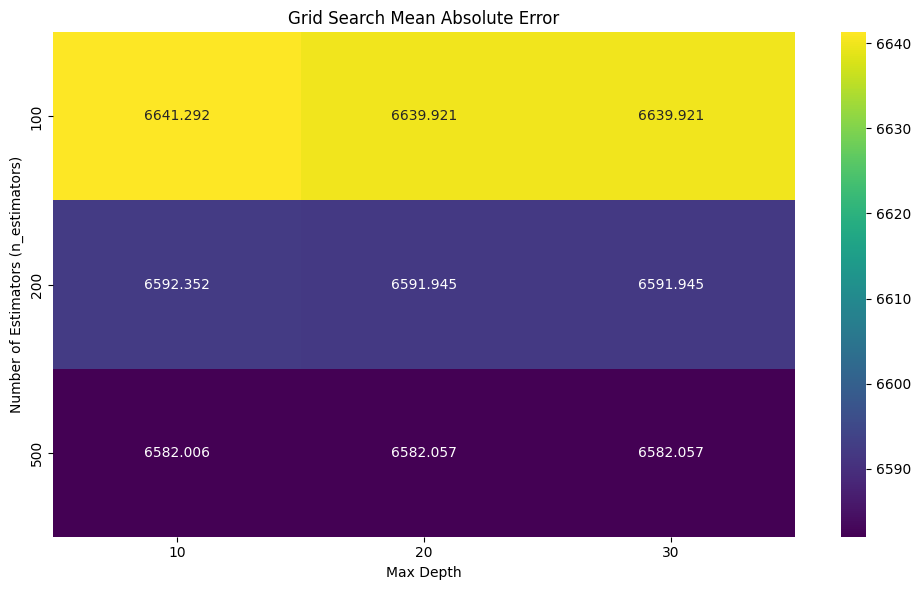

Grid search heatmap saved to ./plots/grid_search_heatmap.png


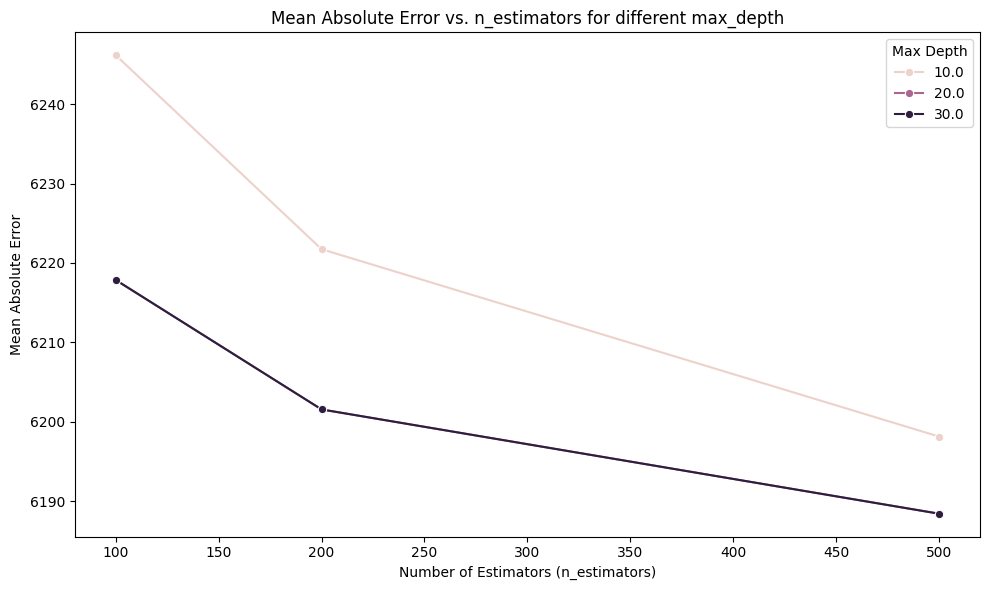

Grid search line plot saved to ./plots/grid_search_lineplot.png


In [9]:
#train a model using a random forest regressor algorithm and print out the predictions for the normalized test data.

rf_model = modeling.train_model(normalized_X_train, y_train)


## 3.3 RFR initial testing

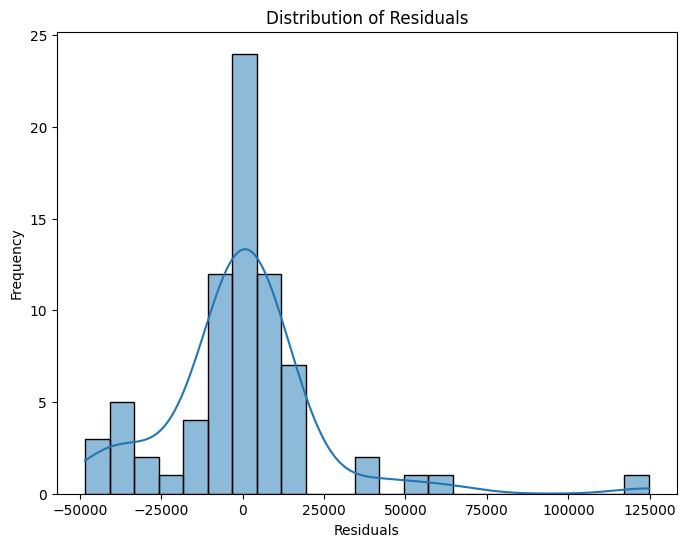

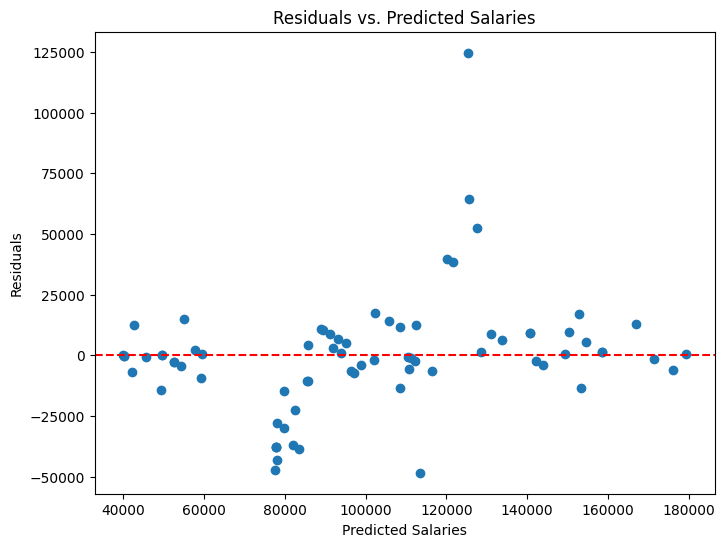

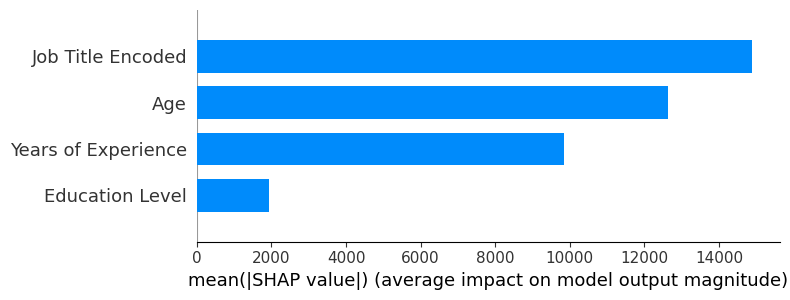

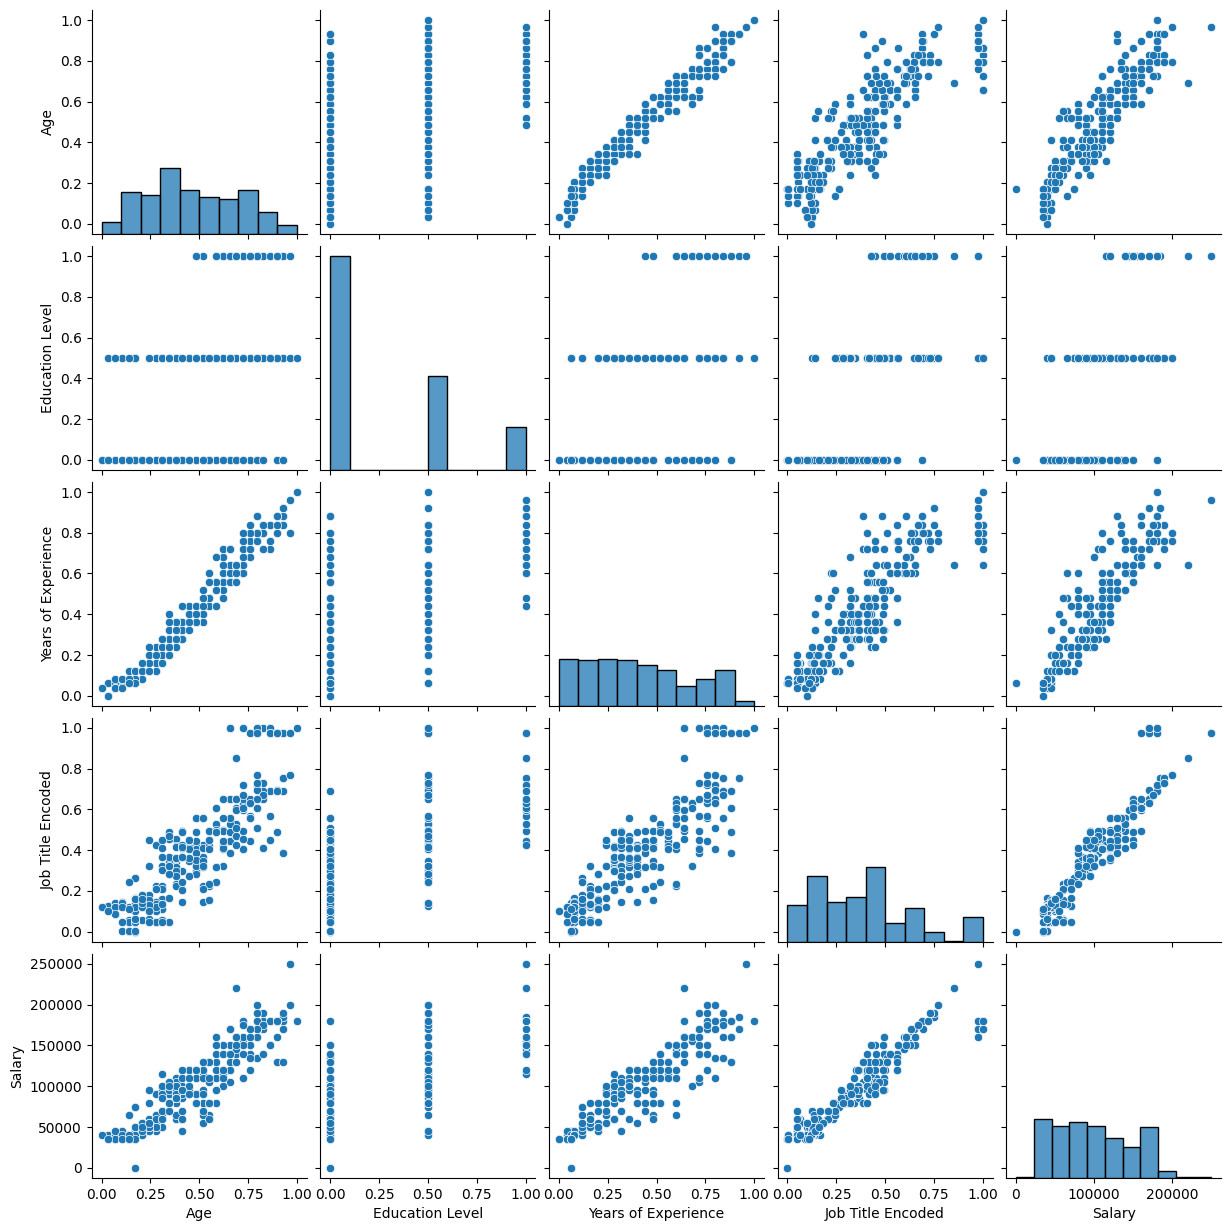

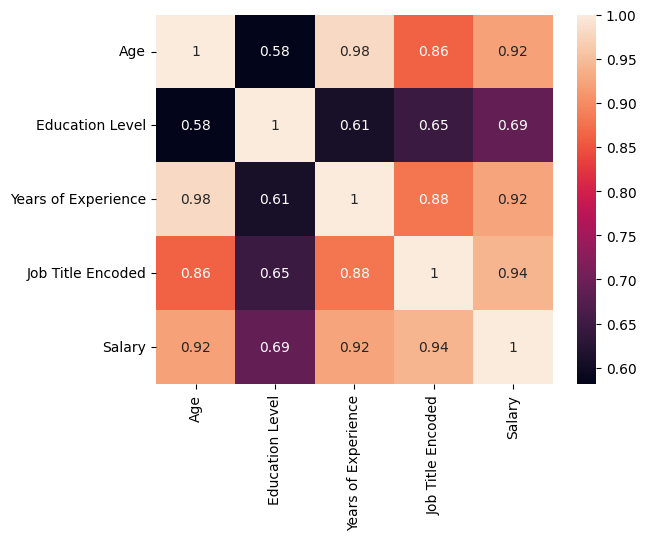

Random Forest Regressor Performance After Hyperparameter Tuning:
Mean Squared Error (MSE): 602080893.94
Mean Absolute Error (MAE): 14710.79
R-squared Score (R²): 0.76


{'mse': 602080893.9380348,
 'mae': 14710.785946127946,
 'r2': 0.7556815988918185,
 'predictions': array([ 49704.93412698, 113389.80555556, 112412.11904762,  91909.57936508,
        133759.53571429, 150376.81746032, 121581.46031746, 108408.28571429,
         52660.13131313, 108539.32142857, 131131.51587302, 120277.38888889,
         77966.10714286,  94034.4047619 , 112316.13492063,  52660.13131313,
         85746.08333333,  79808.9047619 , 140802.37698413,  98932.41666667,
        116433.08333333, 110689.81349206, 125615.23015873,  55026.5952381 ,
         89395.03174603,  59312.72655123, 158451.76190476,  39900.66666667,
        102439.06349206, 171516.92460317,  82129.9047619 ,  93261.88095238,
         82468.4047619 , 140802.37698413, 111173.95634921,  42063.22619048,
        167018.20634921,  78016.04761905, 153371.11507937,  54385.49675325,
         40296.30952381,  89084.20238095, 125312.12698413, 176057.97619048,
         77794.96428571, 142199.97619048, 105830.71031746,  79872.6

In [10]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.


rf_model = joblib.load(open('./models/random_forest_model.pkl', 'rb'))

evaluation.evaluate_model(normalized_X_test, y_test, normalized_X_train,y_train, rf_model)

Next we use Confidence intervals to further test the  models performance using bootstraping 

In [11]:

rf_model = joblib.load(open('./models/random_forest_model.pkl', 'rb'))

evaluation.calculate_metrics(normalized_X_test, y_test, rf_model)

Model Performance with Confidence Intervals:
Mean Squared Error (MSE): 595737604.00 (95% CI: [298619058.25, 1010652280.79])
Mean Absolute Error (MAE): 14658.58 (95% CI: [11060.36, 18660.43])
R-squared Score (R²): 0.76 (95% CI: [0.64, 0.87])


{'mse': {'mean': 595737604.0039821,
  'ci_lower': 298619058.2499654,
  'ci_upper': 1010652280.7852776},
 'mae': {'mean': 14658.576703178454,
  'ci_lower': 11060.356002501205,
  'ci_upper': 18660.431484126988},
 'r2': {'mean': 0.7597481674250709,
  'ci_lower': 0.6353543098407857,
  'ci_upper': 0.870185646933919}}

## 3.4 Feature selection process.



I choose the Random Forest Reggresor to be able to catch non linear relationships better with realtively low data quantity for training, the model is Hyperparametrized using a grid approach and the best model is selected for testing.

In the process of selecting features for the Random Forest Regressor model, based on correlation and feature importance analysis after the first "naive" model was trained in the normalized data as is to gather more information on the relationships and model error R-squared Score (R²).

it is also quite notable that the heteroscedasticity present in the middle of the distribution seems to be caused by the dataset itself, most possibly by the lack of examples to fill the distribution appropiately, otherwise the distribution of residuals seems to be acceptable considering there are no statiscally significant outliers in the dataset.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 866064920.96
        Mean Absolute Error (MAE): 17982.33
        R-squared Score (R²): 0.65
        
![img](./plots/residuals_distribution.png)
![Feature Importance](./plots/feature_importance.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap.png)



It can be seen now better results by droping geneder since it has a really low correlation with salary and importance , and lower the smoothing for the encoded job titles to 3 (10 was the previous value).

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 600148032.12
        Mean Absolute Error (MAE): 14748.68
        R-squared Score (R²): 0.76

![img](./plots/residuals_distribution_2.png)
![Feature Importance](./plots/feature_importance_2.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_2.png)

        
next feature to remove, surprinsingly is education level wich has a low correlation with salary, but if pruned from the dataset the model shows performs worst than before with the same hyperparametrization.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 808374516.33
        Mean Absolute Error (MAE): 17240.95
        R-squared Score (R²): 0.67

![img](./plots/residuals_distribution_3.png)
![Feature Importance](./plots/feature_importance_3.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_3.png)



## 3.5 Neural Network Model

in this step we create a second model to test performance of different approaches in this specific problem. I'm using the same dataset and features as the random forest regressor but normalized using the stardad scaling between  wich provides better performances on NN sequiential models.

2025-01-16 18:26:05.451305: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-16 18:26:07.860619: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-16 18:26:07.860711: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-16 18:26:07.861859: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-16 18:26:07.861963: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Epoch 1/1000


I0000 00:00:1737062769.340578  180134 service.cc:146] XLA service 0x7d4b9400d400 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737062769.340609  180134 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 6900 XT, AMDGPU ISA version: gfx1030
2025-01-16 18:26:09.357614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/9 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - loss: 14817918976.0000

I0000 00:00:1737062772.315090  180134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 506ms/step - loss: 12460851200.0000 - val_loss: 12459918336.0000
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12441607168.0000 - val_loss: 12459846656.0000
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12837251072.0000 - val_loss: 12459752448.0000
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12753784832.0000 - val_loss: 12459607040.0000
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12123314176.0000 - val_loss: 12459359232.0000
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12815003648.0000 - val_loss: 12458973184.0000
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12305726464.0000 - val_loss: 12458382336.0000
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12133820416.0000 - val_loss: 12457534464.0000
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11926131712.0000 - val_loss: 12456307712.0000
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12581921792.0000

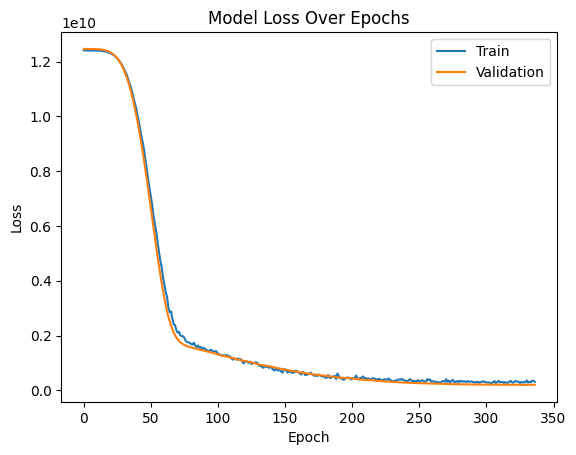

DEBUG:h5py._conv:Creating converter from 5 to 3


Training loss plot saved to ./plots/nn_training_loss.png
Neural Network model saved to ./models/neural_network_model.keras


In [12]:
nn_model = modeling.train_NN_model(normalized_X_train_nn,y_train)

## 3.6 Neural Network Model initial testing

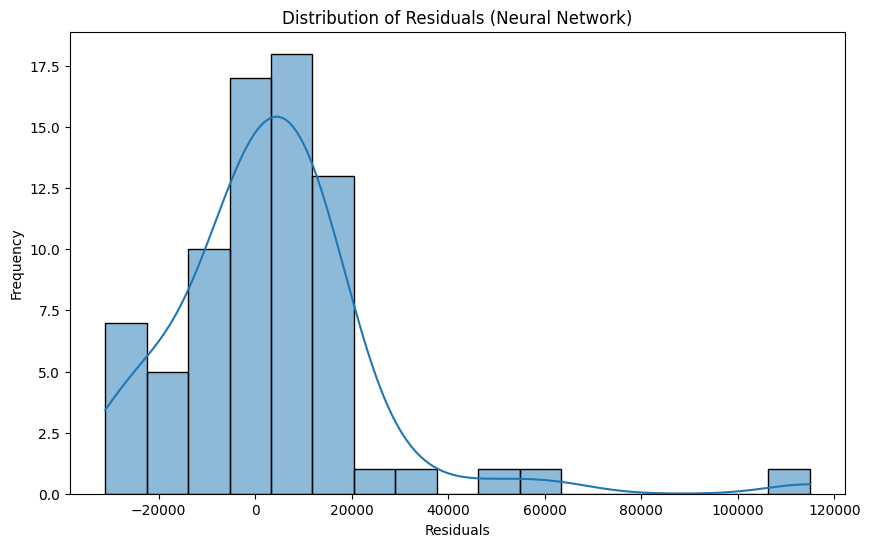

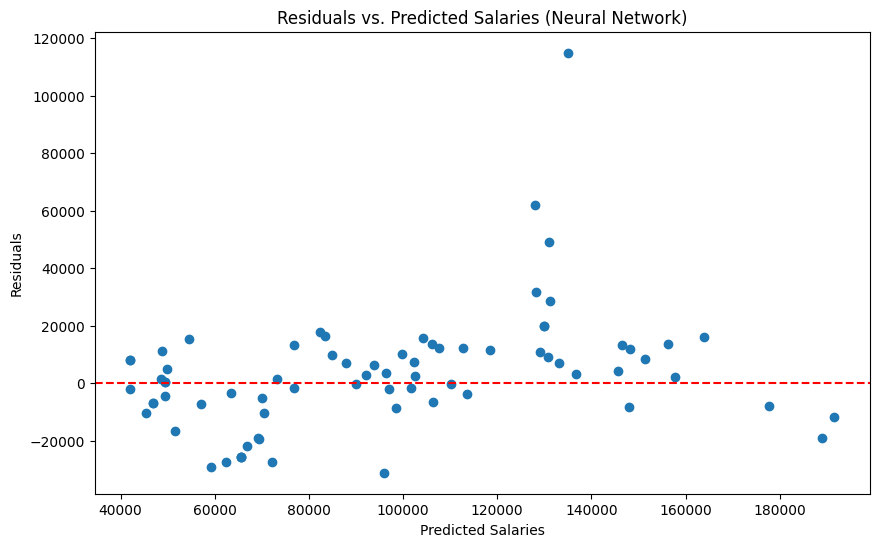

  0%|          | 0/75 [00:00<?, ?it/s]

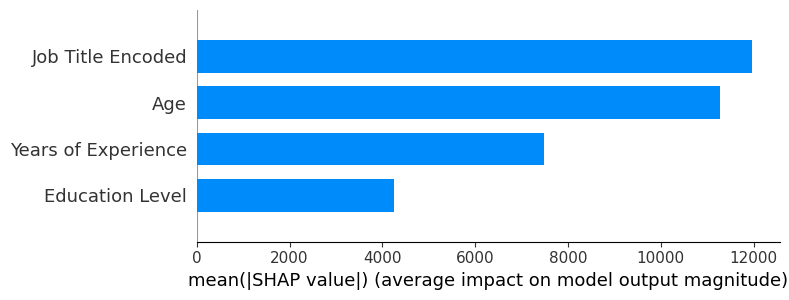


Neural Network Performance:
MSE: 449575709.50
MAE: 13848.40
R-squared Score (R²): 0.82


{'mse': 449575709.50191426,
 'mae': 13848.401822916667,
 'r2': 0.8175666764574521,
 'predictions': array([ 41976.066,  96044.9  , 112744.22 ,  87823.52 , 130835.1  ,
        146579.66 , 131228.69 , 106213.47 ,  49352.082,  97057.11 ,
        129108.06 , 128147.94 ,  62489.793,  84986.62 , 110153.01 ,
         49352.082,  76736.86 ,  69488.69 , 129903.586,  92191.23 ,
        113535.41 , 102610.38 , 128029.97 ,  54454.207,  83407.62 ,
         57120.918, 157848.61 ,  41988.184, 107594.945, 177751.7  ,
         66853.69 , 101781.29 ,  70383.02 , 129903.586,  99813.04 ,
         45432.33 , 163962.73 ,  69094.55 , 148040.6  ,  48495.4  ,
         46803.88 ,  82284.61 , 135115.52 , 189040.66 ,  65622.62 ,
        133047.88 , 104220.086,  70136.49 ,  49912.82 ,  65622.62 ,
         51531.08 ,  90081.266, 118385.6  ,  96378.83 , 102421.82 ,
        148188.3  , 156281.06 ,  63383.3  ,  41976.066,  93772.8  ,
        106299.34 , 145707.78 , 130945.29 ,  76736.86 ,  72197.61 ,
         65622.62 

In [13]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.

nn_model = keras.models.load_model('./models/neural_network_model.keras')

evaluation.evaluate_NN_model(normalized_X_test_nn, y_test,normalized_X_train_nn, nn_model)

In [14]:
nn_model = keras.models.load_model('./models/neural_network_model.keras')


evaluation.calculate_metrics(normalized_X_test_nn, y_test, nn_model)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

{'mse': {'mean': 444579471.8943032,
  'ci_lower': 210391131.94796732,
  'ci_upper': 793721834.320544},
 'mae': {'mean': 13789.039938072916,
  'ci_lower': 11009.5370390625,
  'ci_upper': 16947.823127604166},
 'r2': {'mean': 0.8217219473786542,
  'ci_lower': 0.7100574538154408,
  'ci_upper': 0.9069009281321414}}

# 4 Model Comparison
Comparing the performance of all models using metrics such as accuracy, mean squared error (MSE), and R-squared to determine the best-performing model.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


/home/haervwe/Predictive_Models/salary_predictive_model/src/model_compare.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(results.keys(), rotation=45)
/home/haervwe/Predictive_Models/salary_predictive_model/src/model_compare.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(results.keys(), rotation=45)
/home/haervwe/Predictive_Models/salary_predictive_model/src/model_compare.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(results.keys(), rotation=45)


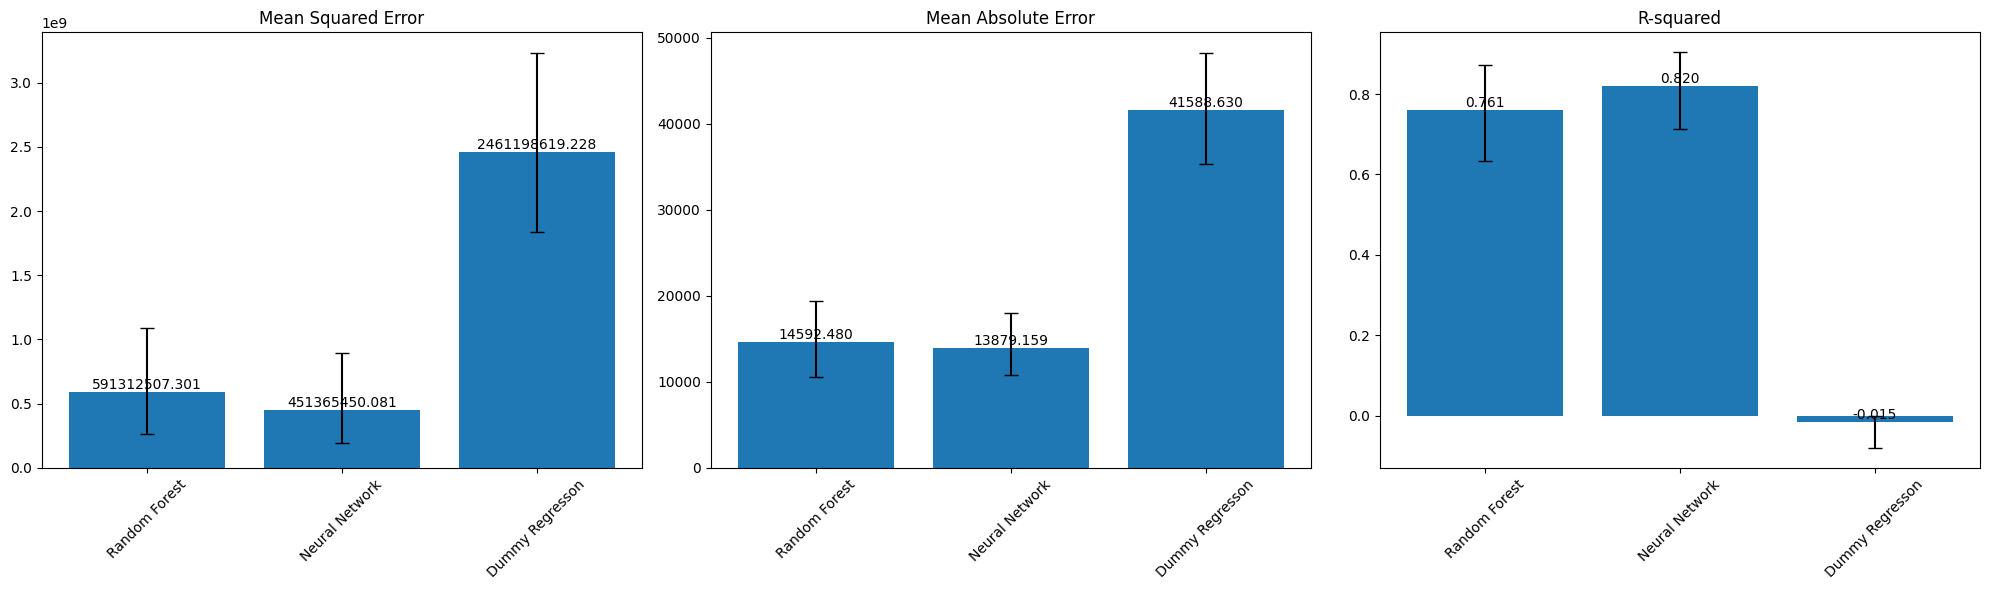

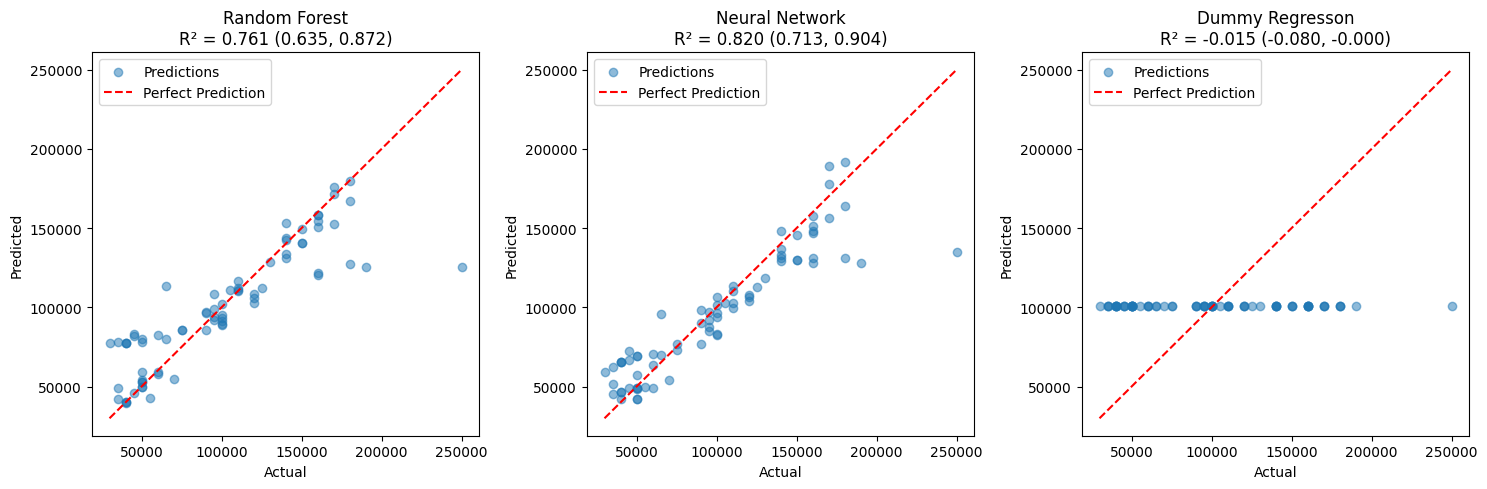

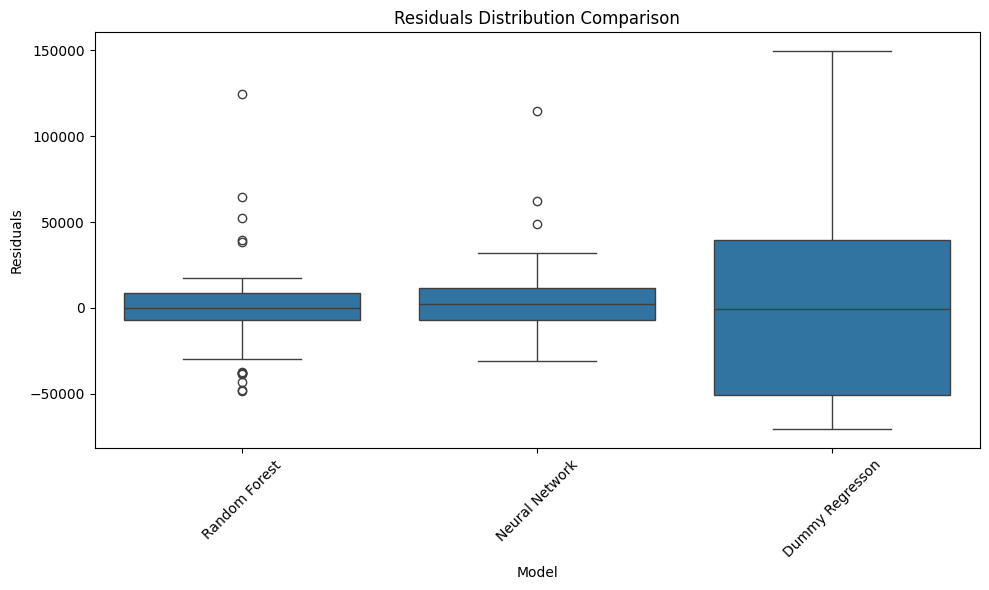


Model Performance Summary with Confidence Intervals:
----------------------------------------------------------------------

Random Forest:
MSE: 591312507.301 (95% CI: [266726953.202, 1092637456.989])
MAE: 14592.480 (95% CI: [10587.479, 19339.949])
R2: 0.761 (95% CI: [0.635, 0.872])

Neural Network:
MSE: 451365450.081 (95% CI: [193911315.376, 891479517.642])
MAE: 13879.159 (95% CI: [10770.149, 17989.091])
R2: 0.820 (95% CI: [0.713, 0.904])

Dummy Regresson:
MSE: 2461198619.228 (95% CI: [1834308694.379, 3231299942.415])
MAE: 41588.630 (95% CI: [35333.317, 48193.295])
R2: -0.015 (95% CI: [-0.080, -0.000])


In [15]:
nn_model = keras.models.load_model('./models/neural_network_model.keras')
dummy = joblib.load(open('./models/dummy_reggresor_model.pkl', 'rb'))
rf_model = joblib.load(open('./models/random_forest_model.pkl', 'rb'))



models_data = {
    'Random Forest': (rf_model, normalized_X_test, y_test),
    'Neural Network': (nn_model, normalized_X_test_nn, y_test),
    'Dummy Regresson': (dummy, normalized_X_test, y_test)
}

comparison_results = model_compare.compare_models(models_data, y_test)


### 4.1 Final Model Selection

After generation both aproaches for modeling the problem i settled on using the neural network approach since it seems to capture better the relationships between the features and is in general more precise.

we can observe the comparisons on the following charts:

![img](./plots/predicted_vs_actual_values_model_comparison.png)


![img](./plots/error_model_comparison.png)


![img](./plots/residuals_distribution_model_comparison.png)


And the reported confidence intervals with bootstraping for each model: 

### **Model Performance Summary with Confidence Intervals**:
----------------------------------------------------------------------

**Random Forest**:
MSE: 591312507.301 (95% CI: [266726953.202, 1092637456.989])
MAE: 14592.480 (95% CI: [10587.479, 19339.949])
R2: 0.761 (95% CI: [0.635, 0.872])

**Neural Network**:
MSE: 451365450.081 (95% CI: [193911315.376, 891479517.642])
MAE: 13879.159 (95% CI: [10770.149, 17989.091])
R2: 0.820 (95% CI: [0.713, 0.904])

**Dummy Regresson**:
MSE: 2461198619.228 (95% CI: [1834308694.379, 3231299942.415])
MAE: 41588.630 (95% CI: [35333.317, 48193.295])
R2: -0.015 (95% CI: [-0.080, -0.000])



# 5 Inference

Using the best-performing model to make predictions on new or unseen data. This step involves applying the trained model to real-world scenarios or test cases.

In [3]:
job_titles = inference.get_unique_job_titles(prefix="nn_")
form = create_input_form(job_titles)
display(form)

DEBUG:Comm:handle_msg[4afdf10ad774401abc4e378118b7b542]({'header': {'date': datetime.datetime(2025, 1, 16, 21, 32, 12, 549000, tzinfo=tzutc()), 'msg_id': '20dc7229-9244-43bf-93d8-a30bef96c7d3', 'msg_type': 'comm_msg', 'session': '1bad45e7-d484-430d-a1cc-f312244ca629', 'username': '19cfe35d-23e9-498a-9755-af88d33f4455', 'version': '5.2'}, 'msg_id': '20dc7229-9244-43bf-93d8-a30bef96c7d3', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '4afdf10ad774401abc4e378118b7b542', 'data': {'method': 'custom', 'content': {'event': 'click'}}}, 'buffers': []})
DEBUG:Comm:handle_msg[2315ad71ed624913a1a9ea83c49237c3]({'header': {'date': datetime.datetime(2025, 1, 16, 21, 32, 26, 822000, tzinfo=tzutc()), 'msg_id': '9338727c-54d2-4c9d-b8fb-f9ae4c9b3288', 'msg_type': 'comm_msg', 'session': '1bad45e7-d484-430d-a1cc-f312244ca629', 'username': '19cfe35d-23e9-498a-9755-af88d33f4455', 'version': '5.2'}, 'msg_id': '9338727c-54d2-4c9d-b8fb-f9ae4c9b3288', 'msg_type': 'comm_msg'